Now try the experiment 0a in LeNet embedding space. In LeNet architecture there are both convoltution and fully connected layers.

<img src = 'images/emGAN.png' width=500 height=500/>

where **generator G** is fully convolutional as follows :-

<img src = 'images/emGAN_G.png' width=300 height=300/>

and **discriminator D** is densely connected as follows :-

<img src = 'images/emGAN_E_full.png' width=300 height=300/>

The **embedding network E** contains two convolutional layers initialized with random weights which are fixed. So, we can say that the embedding network is a fixed mapping from the output space of the generator to the input space of discriminator :- 

<img src = 'images/emGAN_D_full.png' width=300 height=300/>

In [1]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

In [2]:
from model_exp0b import Generator, Discriminator, EmbeddingNet

In [3]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [4]:
batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

In [5]:
modelFolder = 'dummy'

GInitF = 'G_init.pt'
DInitF = 'D_init.pt'
EInitF = 'E_init.pt'

GFinalF = 'G_fin.pt'
DFinalF = 'D_fin.pt'
EFinalF = 'E_fin.pt'


def change():
    
    GInit = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator()
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator()
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'


In [6]:
def train(primaryTrainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    D = Discriminator()
    E = EmbeddingNet(numPrimaryOutputChannels)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    E.weight_init(mean=0.0, std=0.02)
    
    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EInitF
    torch.save(E.state_dict(), PATH)
    
    
    # setting the require_grad as False for all parameters pertaining thera and phi
    for param in E.parameters():
        param.require_grad=False
    
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numNoiseChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        E = E.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(primaryTrainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            discRealInputEmbedding = E(discRealInputV)
            
            #print discRealInputV.data.shape, discRealInputEmbedding.data.shape

            #print discRealInput.shape
            discRealOutput = D(discRealInputEmbedding)
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            genFakeOutputEmbedding = E(genFakeOutput)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutputEmbedding.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutputEmbedding)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EFinalF
    torch.save(E.state_dict(), PATH)

In [7]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/5] time: 0.95, loss_d: 1.398, loss_g: 0.590
Epoch : [2/5] time: 0.86, loss_d: 1.397, loss_g: 0.592
Epoch : [3/5] time: 0.86, loss_d: 1.397, loss_g: 0.595
Epoch : [4/5] time: 0.95, loss_d: 1.396, loss_g: 0.598
Epoch : [5/5] time: 0.96, loss_d: 1.396, loss_g: 0.601


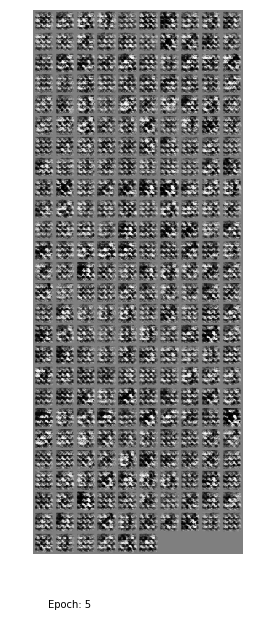

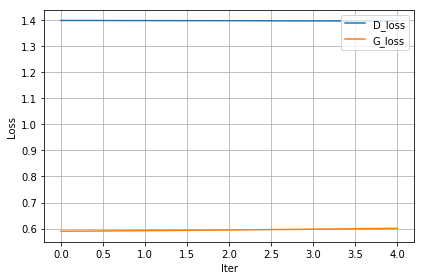

In [23]:
train(primayTrainLoader, epochs=5)


Epoch : [1/30] time: 0.95, loss_d: 1.396, loss_g: 0.597
Epoch : [2/30] time: 0.86, loss_d: 1.396, loss_g: 0.600
Epoch : [3/30] time: 0.86, loss_d: 1.395, loss_g: 0.603
Epoch : [4/30] time: 0.86, loss_d: 1.394, loss_g: 0.606
Epoch : [5/30] time: 0.86, loss_d: 1.394, loss_g: 0.609
Epoch : [6/30] time: 0.86, loss_d: 1.393, loss_g: 0.613
Epoch : [7/30] time: 0.91, loss_d: 1.392, loss_g: 0.617
Epoch : [8/30] time: 0.86, loss_d: 1.392, loss_g: 0.622
Epoch : [9/30] time: 0.86, loss_d: 1.391, loss_g: 0.627
Epoch : [10/30] time: 0.87, loss_d: 1.390, loss_g: 0.631
Epoch : [11/30] time: 0.86, loss_d: 1.390, loss_g: 0.636
Epoch : [12/30] time: 0.86, loss_d: 1.389, loss_g: 0.641
Epoch : [13/30] time: 0.87, loss_d: 1.389, loss_g: 0.647
Epoch : [14/30] time: 0.85, loss_d: 1.388, loss_g: 0.652
Epoch : [15/30] time: 0.86, loss_d: 1.388, loss_g: 0.657
Epoch : [16/30] time: 0.86, loss_d: 1.387, loss_g: 0.661
Epoch : [17/30] time: 0.86, loss_d: 1.387, loss_g: 0.666
Epoch : [18/30] time: 0.85, loss_d: 1.38

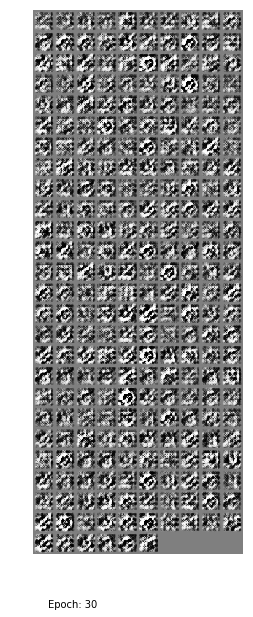

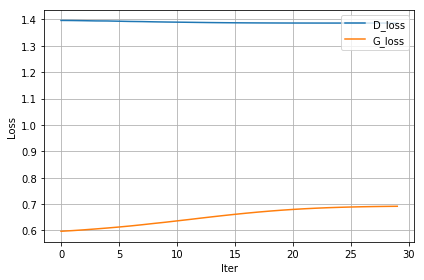

In [24]:
train(primayTrainLoader, epochs=30)


Epoch : [1/300] time: 0.96, loss_d: 1.389, loss_g: 0.639
Epoch : [2/300] time: 0.82, loss_d: 1.389, loss_g: 0.641
Epoch : [3/300] time: 0.81, loss_d: 1.389, loss_g: 0.643
Epoch : [4/300] time: 0.81, loss_d: 1.389, loss_g: 0.646
Epoch : [5/300] time: 0.81, loss_d: 1.389, loss_g: 0.648
Epoch : [6/300] time: 0.81, loss_d: 1.388, loss_g: 0.651
Epoch : [7/300] time: 0.81, loss_d: 1.388, loss_g: 0.653
Epoch : [8/300] time: 0.82, loss_d: 1.388, loss_g: 0.656
Epoch : [9/300] time: 0.81, loss_d: 1.388, loss_g: 0.658
Epoch : [10/300] time: 0.81, loss_d: 1.387, loss_g: 0.661
Epoch : [11/300] time: 0.81, loss_d: 1.387, loss_g: 0.663
Epoch : [12/300] time: 0.81, loss_d: 1.387, loss_g: 0.666
Epoch : [13/300] time: 0.81, loss_d: 1.387, loss_g: 0.668
Epoch : [14/300] time: 0.81, loss_d: 1.387, loss_g: 0.671
Epoch : [15/300] time: 0.81, loss_d: 1.387, loss_g: 0.673
Epoch : [16/300] time: 0.81, loss_d: 1.387, loss_g: 0.676
Epoch : [17/300] time: 0.81, loss_d: 1.387, loss_g: 0.678
Epoch : [18/300] time: 

Epoch : [142/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [143/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [144/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [145/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [146/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [147/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [148/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [149/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [150/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [151/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [152/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [153/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [154/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [155/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [156/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [157/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [158/300] time: 0.82, loss_d: 1.386, loss_g: 0.6

Epoch : [281/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [282/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [283/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [284/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [285/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [286/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [287/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [288/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [289/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [290/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [291/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [292/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [293/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [294/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [295/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [296/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [297/300] time: 0.83, loss_d: 1.386, loss_g: 0.6

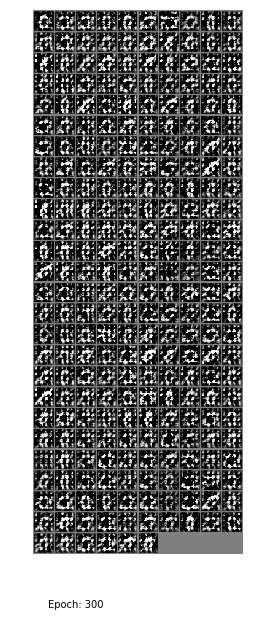

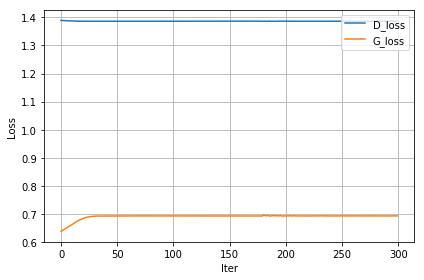

In [25]:
train(primayTrainLoader, epochs=300)


In [11]:
change()

Generator: Weights are different
Discriminator: Weights are different
Embedding: Weights are same


For SVHN dataset

In [26]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/5] time: 0.89, loss_d: 1.390, loss_g: 0.755
Epoch : [2/5] time: 0.81, loss_d: 1.390, loss_g: 0.753
Epoch : [3/5] time: 0.81, loss_d: 1.388, loss_g: 0.750
Epoch : [4/5] time: 0.81, loss_d: 1.389, loss_g: 0.747
Epoch : [5/5] time: 0.81, loss_d: 1.390, loss_g: 0.745


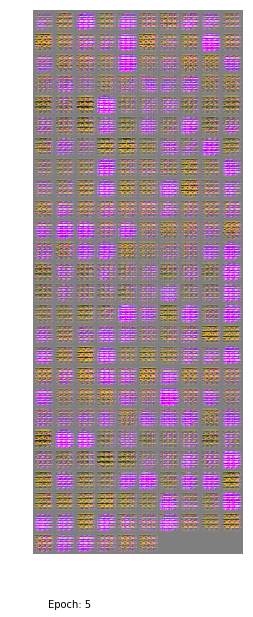

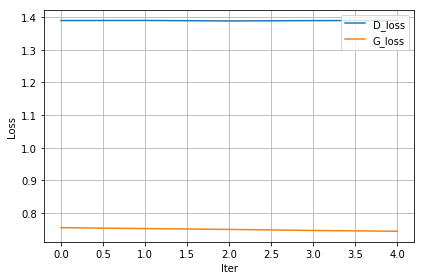

In [27]:
train(primayTrainLoader, epochs=5)

Epoch : [1/30] time: 0.95, loss_d: 1.388, loss_g: 0.735
Epoch : [2/30] time: 0.85, loss_d: 1.388, loss_g: 0.733
Epoch : [3/30] time: 0.85, loss_d: 1.388, loss_g: 0.731
Epoch : [4/30] time: 0.85, loss_d: 1.388, loss_g: 0.730
Epoch : [5/30] time: 0.91, loss_d: 1.387, loss_g: 0.727
Epoch : [6/30] time: 0.85, loss_d: 1.387, loss_g: 0.726
Epoch : [7/30] time: 0.93, loss_d: 1.387, loss_g: 0.723
Epoch : [8/30] time: 0.84, loss_d: 1.387, loss_g: 0.722
Epoch : [9/30] time: 0.85, loss_d: 1.387, loss_g: 0.720
Epoch : [10/30] time: 0.91, loss_d: 1.387, loss_g: 0.718
Epoch : [11/30] time: 0.86, loss_d: 1.387, loss_g: 0.716
Epoch : [12/30] time: 0.85, loss_d: 1.387, loss_g: 0.714
Epoch : [13/30] time: 0.86, loss_d: 1.387, loss_g: 0.712
Epoch : [14/30] time: 0.86, loss_d: 1.387, loss_g: 0.711
Epoch : [15/30] time: 0.88, loss_d: 1.387, loss_g: 0.709
Epoch : [16/30] time: 0.85, loss_d: 1.387, loss_g: 0.707
Epoch : [17/30] time: 0.85, loss_d: 1.386, loss_g: 0.706
Epoch : [18/30] time: 0.85, loss_d: 1.38

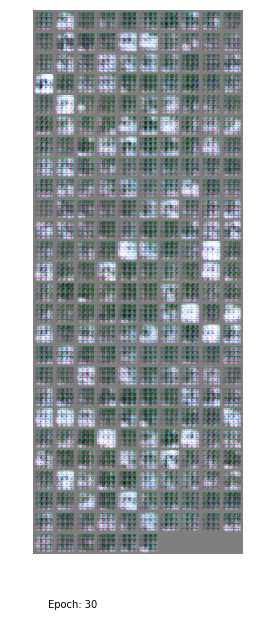

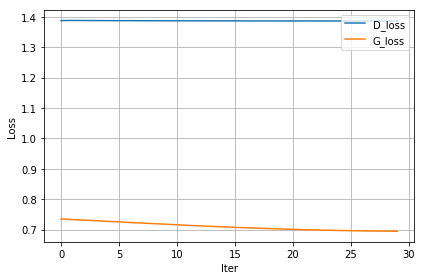

In [28]:
train(primayTrainLoader, epochs=30)

Epoch : [1/300] time: 0.93, loss_d: 1.398, loss_g: 0.805
Epoch : [2/300] time: 0.81, loss_d: 1.397, loss_g: 0.803
Epoch : [3/300] time: 0.81, loss_d: 1.397, loss_g: 0.800
Epoch : [4/300] time: 0.81, loss_d: 1.396, loss_g: 0.798
Epoch : [5/300] time: 0.81, loss_d: 1.396, loss_g: 0.795
Epoch : [6/300] time: 0.82, loss_d: 1.395, loss_g: 0.792
Epoch : [7/300] time: 0.81, loss_d: 1.395, loss_g: 0.789
Epoch : [8/300] time: 0.81, loss_d: 1.394, loss_g: 0.785
Epoch : [9/300] time: 0.81, loss_d: 1.394, loss_g: 0.782
Epoch : [10/300] time: 0.82, loss_d: 1.393, loss_g: 0.778
Epoch : [11/300] time: 0.81, loss_d: 1.392, loss_g: 0.774
Epoch : [12/300] time: 0.81, loss_d: 1.392, loss_g: 0.769
Epoch : [13/300] time: 0.82, loss_d: 1.391, loss_g: 0.765
Epoch : [14/300] time: 0.81, loss_d: 1.391, loss_g: 0.761
Epoch : [15/300] time: 0.81, loss_d: 1.390, loss_g: 0.756
Epoch : [16/300] time: 0.81, loss_d: 1.390, loss_g: 0.751
Epoch : [17/300] time: 0.81, loss_d: 1.389, loss_g: 0.747
Epoch : [18/300] time: 

Epoch : [142/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [143/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [144/300] time: 0.83, loss_d: 1.387, loss_g: 0.693
Epoch : [145/300] time: 0.83, loss_d: 1.386, loss_g: 0.694
Epoch : [146/300] time: 0.83, loss_d: 1.386, loss_g: 0.694
Epoch : [147/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [148/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [149/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [150/300] time: 0.83, loss_d: 1.386, loss_g: 0.694
Epoch : [151/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [152/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [153/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [154/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [155/300] time: 0.83, loss_d: 1.386, loss_g: 0.694
Epoch : [156/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [157/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [158/300] time: 0.82, loss_d: 1.386, loss_g: 0.6

Epoch : [281/300] time: 0.82, loss_d: 1.386, loss_g: 0.693
Epoch : [282/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [283/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [284/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [285/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [286/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [287/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [288/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [289/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [290/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [291/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [292/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [293/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [294/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [295/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [296/300] time: 0.83, loss_d: 1.386, loss_g: 0.693
Epoch : [297/300] time: 0.82, loss_d: 1.386, loss_g: 0.6

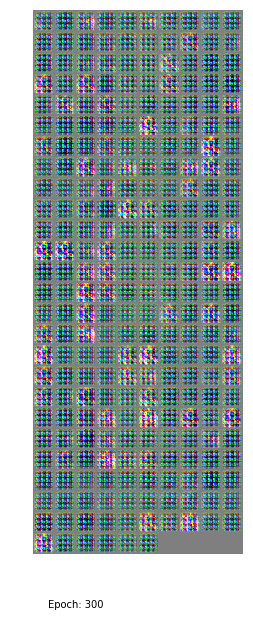

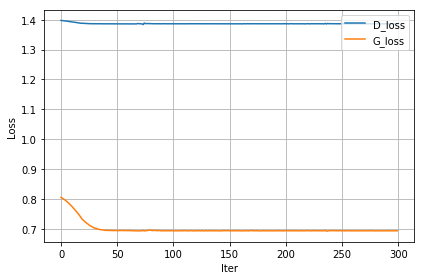

In [29]:
train(primayTrainLoader, epochs=300)